In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.pca_translation_utils import *


warnings.filterwarnings('ignore')

In [ ]:
transform = Reshape2DField()

cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
sqh_info = get_pca_results(sqh_dataset)
cad_info = get_pca_results(cad_dataset)
vel_info = get_pca_results(vel_dataset)

 48%|████▊     | 10/21 [00:00<00:00, 12.91it/s]

In [ ]:
from math import ceil

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 0.

N = 3
t0 = 20
t1 = 36
dt = (t1 - t0) // N

fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(3, N+2)

with h5py.File('tensor_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    
    vmin = 0
    vmax = lib['fields/v'].attrs['max']
    vwargs = dict(skip=20, vmin=vmin, vmax=vmax)

    vmin = lib['fields/m'].attrs['std']
    vmax = lib['fields/m'].attrs['max']
    mwargs = dict(skip=20, vmin=vmin, vmax=vmax)

    vmin = lib['fields/c'].attrs['std']
    vmax = lib['fields/c'].attrs['max']
    cwargs = dict(skip=20, vmin=vmin, vmax=vmax)
    
    t0 = np.argmin(np.abs(lib['t'][()] - t0))
    t1 = np.argmin(np.abs(lib['t'][()] - t1))

    ax = fig.add_subplot(gs[0, 0])
    plot_vector2D(ax, lib['fields/v'][t0], **vwargs)
    ax.set_aspect('auto')
    
    ax = fig.add_subplot(gs[0, -1])
    plot_vector2D(ax, lib['fields/v'][t1], **vwargs)
    ax.set_aspect('auto')
    
    ax = fig.add_subplot(gs[1, 0])
    plot_tensor2D(ax, lib['fields/m'][t0], **mwargs)
    ax.set_aspect('auto')
    
    ax = fig.add_subplot(gs[1, -1])
    plot_tensor2D(ax, lib['fields/m'][t1], **mwargs)
    ax.set_aspect('auto')
    
    ax = fig.add_subplot(gs[2, 0])
    plot_tensor2D(ax, lib['fields/c'][t0], **cwargs)
    ax.set_aspect('auto')
    
    ax = fig.add_subplot(gs[2, -1])
    plot_tensor2D(ax, lib['fields/c'][t1], **cwargs)
    ax.set_aspect('auto')
    
    for i in range(N):
        ax = fig.add_subplot(gs[1, i+1])
        plot_tensor2D(ax, lib['X_dot/m'][t0+i*N, ..., 0], skip=20)
        ax.set_aspect('auto')
        
        ax = fig.add_subplot(gs[2, i+1])
        plot_tensor2D(ax, lib['X_dot/c'][t0+i*N, ..., 0], skip=20)
        ax.set_aspect('auto')
        
        
plt.savefig('Figures/full_dynamics.svg', bbox_inches='tight')

## Evolution from initial conditions

$$\dot{m}_{ij} = 0.5 c_{ij} (c_{kl} \nabla_k v_l) - 11 m_{ij} (m_{kl} \nabla_k v_l)$$

$$\dot{c}_{ij} = 1.8 (\mathbf{v} \cdot \nabla) c_{ij} + 1.3 c_{ij} (c_{kl} \nabla_k v_l) + 7 \big[ (\mathbf{v} \cdot \nabla) m_{ij} - 0.2 m_{ij} (\nabla \cdot \mathbf{v}) - 7 m_{ij} (m_{kl} \nabla_k v_l) \big] $$

In [175]:
from tqdm import tqdm
from pysindy import SmoothedFiniteDifference
from scipy.io import loadmat
from scipy.interpolate import interp1d

from utils.pca_translation_utils import *
from sklearn.decomposition import PCA
import pickle as pk

geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

cad_model = pk.load(open('/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/ECad-GFP/tensor_PCA.pkl', 'rb'))
myo_model = pk.load(open('/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh-mCherry/tensor_PCA.pkl', 'rb'))

keep_c = np.ones_like(cad_model.explained_variance_ratio_ >= 0)
keep_m = np.ones_like(myo_model.explained_variance_ratio_ >= 0)

#keep_c = np.cumsum(cad_model.explained_variance_ratio_) <= 0.99
#keep_m = np.cumsum(myo_model.explained_variance_ratio_) <= 0.99

def mdot(m, c, v, d1_m, d1_c, d1_v):
    return 0.449 * np.einsum('ijyx,klyx,kyxl->ijyx', c, c, d1_v) + \
           -11.3 * np.einsum('ijyx,klyx,kyxl->ijyx', m, m, d1_v)

def cdot(m, c, v, d1_m, d1_c, d1_v):
    return 1.74 * np.einsum('kyx,ijyxk->ijyx', v, d1_c) + \
           1.34 * np.einsum('ijyx,klyx,kyxl->ijyx', c, c, d1_v) + \
           7.33 * np.einsum('kyx,ijyxk->ijyx', v, d1_m) + \
           -2.0 * np.einsum('ijyx,kyxk->ijyx', m, d1_v) + \
           -50.4 * np.einsum('ijyx,klyx,kyxl->ijyx', m, m, d1_v)

def xdot(m, c, v):
    diffY = ps.SmoothedFiniteDifference(d=1, axis=-2)
    diffX = ps.SmoothedFiniteDifference(d=1, axis=-1)
    diffY.smoother_kws['axis'] = -2
    diffX.smoother_kws['axis'] = -1
    d1_m = np.stack([
        diffY._differentiate(m, YY),
        diffX._differentiate(m, XX),
    ], axis=-1)
    
    d1_c = np.stack([
        diffY._differentiate(c, YY),
        diffX._differentiate(c, XX),
    ], axis=-1)
    
    diffY = ps.SmoothedFiniteDifference(d=1, axis=-2)
    diffX = ps.SmoothedFiniteDifference(d=1, axis=-1)
    diffY.smoother_kws['axis'] = -2
    diffX.smoother_kws['axis'] = -1
    
    d1_v = np.stack([
        diffY._differentiate(v, YY),
        diffX._differentiate(v, XX),
    ], axis=-1)
    
    return mdot(m, c, v, d1_m, d1_c, d1_v), \
           cdot(m, c, v, d1_m, d1_c, d1_v)
    
def evolve_rk4(m, c, v, tmin=0, tmax=10, hh=0.2):
    '''
    RK4 evolution of myosin, cadherin fields from initial conditions
    v is an interpolating function for the flow field
    '''
    
    tt = np.arange(tmin, tmax, hh)
    
    m0 = m(tmin)
    c0 = c(tmin)
    mi = np.zeros([len(tt), *m0.shape])
    ci = np.zeros([len(tt), *c0.shape])
    
    mi[0] = m0
    ci[0] = c0
    
    for ii in tqdm(range(len(tt)-1)):
        k1_m, k1_c = xdot(mi[ii], 
                          ci[ii], 
                          v(tt[ii]))
        k2_m, k2_c = xdot(mi[ii] + 0.5*hh * k1_m,
                          ci[ii] + 0.5*hh * k1_c,
                          v(tt[ii]+0.5*hh))
        k3_m, k3_c = xdot(mi[ii] + 0.5*hh * k2_m,
                          ci[ii] + 0.5*hh * k2_c,
                          v(tt[ii]+0.5*hh))
        k4_m, k4_c = xdot(mi[ii] + hh*k3_m,
                          ci[ii] + hh*k3_c,
                          v(tt[ii]+hh))
    
        mtt = mi[ii] + (k1_m + 2*k2_m + 2*k3_m + k4_m) * hh / 6.
        ctt = ci[ii] + (k1_c + 2*k2_c + 2*k3_c + k4_c) * hh / 6.
        
        mtt = mtt.reshape([1, -1])
        mtt = unpca(myo_model.transform(mtt)[:, keep_m], myo_model, keep_m).reshape(ctt.shape)
        ctt = ctt.reshape([1, -1])
        ctt = unpca(cad_model.transform(ctt)[:, keep_c], cad_model, keep_c).reshape(mtt.shape)

        mi[ii+1] = mtt
        ci[ii+1] = ctt

    return mi, ci, tt

with h5py.File('tensor_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    
    v0 = interp1d(lib['t'], lib['fields/v'], axis=0)
    m0 = interp1d(lib['t'], lib['fields/m'], axis=0)
    c0 = interp1d(lib['t'], lib['fields/c'], axis=0)
    
    tmin, tmax = 15, 45
    
    m, c, times = evolve_rk4(m0, c0, v0, tmin, tmax)
    
    m0 = m0(times)
    c0 = c0(times)
    v0 = v0(times)

100%|██████████| 149/149 [00:26<00:00,  5.59it/s]


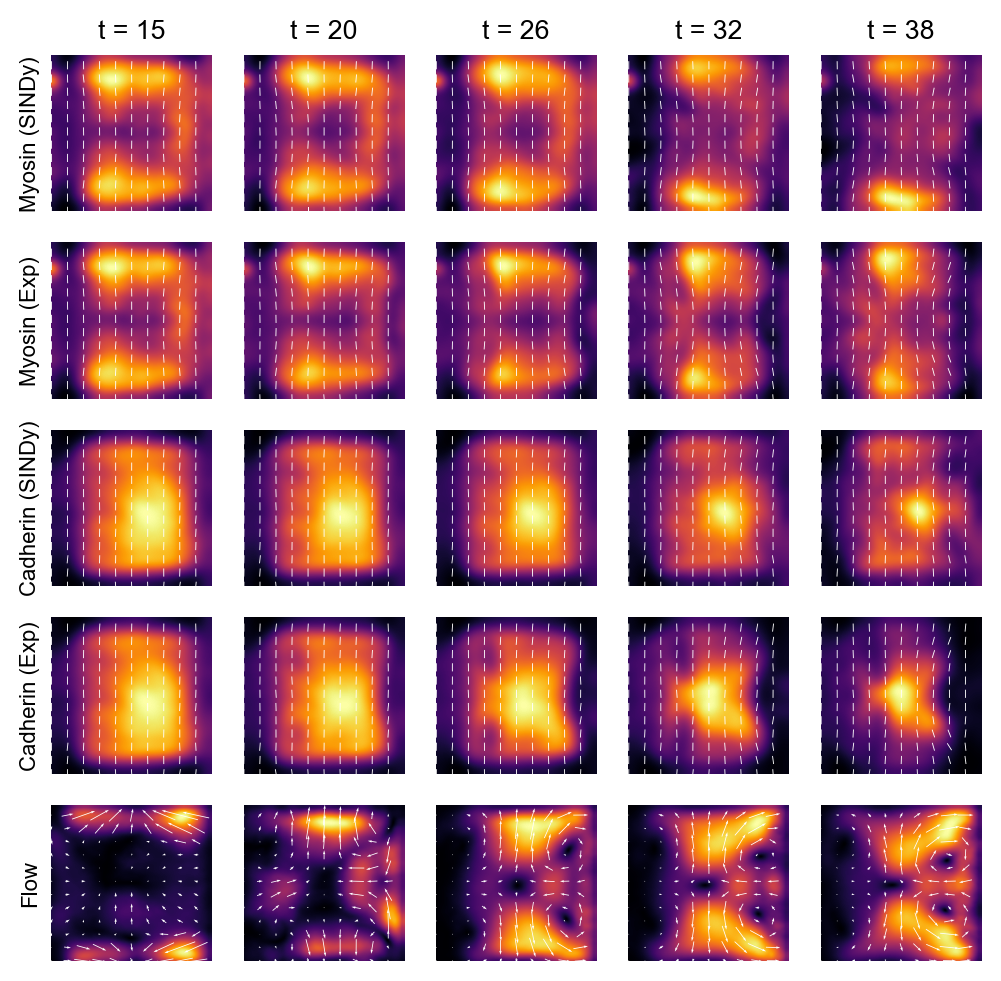

In [176]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 0.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

N = 5
dt = len(times) // N

fig, ax = plt.subplots(5, N, figsize=(6, 6))

for i in range(N):
    ax[0, i].set_title('t = %d' % times[dt*i])
    
    plot_tensor2D(ax[0, i], m[dt*i])
    plot_tensor2D(ax[1, i], m0[dt*i])
    
    plot_tensor2D(ax[2, i], c[dt*i])
    plot_tensor2D(ax[3, i], c0[dt*i])
    
    plot_vector2D(ax[4, i], v0[dt*i], skip=20)
    
ax[0, 0].set_ylabel('Myosin (SINDy)')
ax[1, 0].set_ylabel('Myosin (Exp)')

ax[2, 0].set_ylabel('Cadherin (SINDy)')
ax[3, 0].set_ylabel('Cadherin (Exp)')

ax[4, 0].set_ylabel('Flow')
    
for a in ax.flatten():
    a.set_aspect('auto')

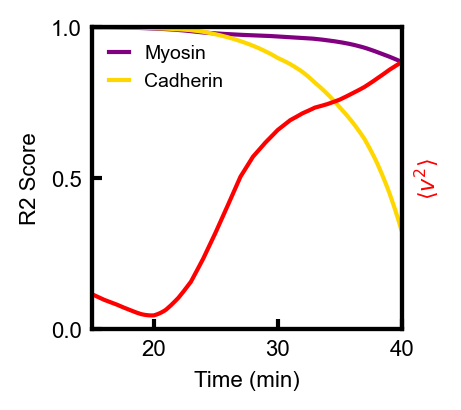

In [181]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0

from sklearn.metrics import r2_score

v2 = np.linalg.norm(v0, axis=1).mean(axis=(1, 2))

def score(x, x0, model):
    x0_trans = model.transform(x0.reshape([x.shape[0], -1]))
    x0_trans = model.inverse_transform(x0_trans)
    
    x_trans = model.transform(x.reshape([x.shape[0], -1]))
    x_trans = model.inverse_transform(x_trans)
    return r2_score(
        x0_trans.T,
        x_trans.T,
        multioutput='raw_values')

r2_myo = score(m, m0, myo_model)
r2_cad = score(c, c0, cad_model)

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.plot(times, r2_myo, color='purple', label='Myosin')
ax.plot(times, r2_cad, color='gold', label='Cadherin')
ax.set(xlim=[15, 40],
       xlabel='Time (min)',
       ylim=[0, 1], yticks=[0, 0.5, 1],
       ylabel='R2 Score')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(times, v2, color='red')
ax2.set_yticks([])
ax2.set_ylabel('$\\langle v^2 \\rangle$', color='red')

plt.savefig('Figures/closed_loop_forecasting.svg', bbox_inches='tight')

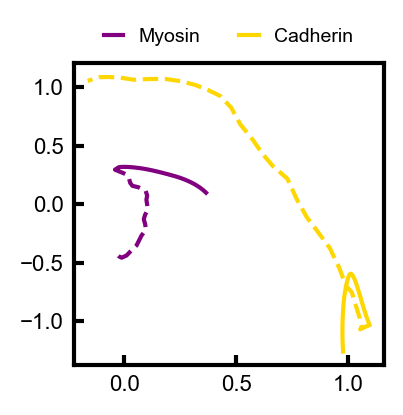

In [196]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0

m0_pca0 = myo_model.transform(m0.reshape([m0.shape[0], -1]))[:, 0]
m0_pca1 = myo_model.transform(m0.reshape([m0.shape[0], -1]))[:, 1]
m_pca0 = myo_model.transform(m.reshape([m.shape[0], -1]))[:, 0]
m_pca1 = myo_model.transform(m.reshape([m.shape[0], -1]))[:, 1]

c0_pca0 = cad_model.transform(c0.reshape([c0.shape[0], -1]))[:, 0]
c0_pca1 = cad_model.transform(c0.reshape([c0.shape[0], -1]))[:, 1]
c_pca0 = cad_model.transform(c.reshape([c.shape[0], -1]))[:, 0]
c_pca1 = cad_model.transform(c.reshape([c.shape[0], -1]))[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

def plot(p0, p1, **kwargs):
    ax.plot(
        p0, p1, **kwargs)
    #ax.plot((p0 - np.mean(p0)) / np.std(p0),
    #        (p1 - np.mean(p1)) / np.std(p1), **kwargs)

plot(m0_pca0, m0_pca1, color='purple', linestyle='--')
plot(m_pca0, m_pca1, color='purple', label='Myosin')
plot(c0_pca0, c0_pca1, color='gold', linestyle='--')
plot(c_pca0, c_pca1, color='gold', label='Cadherin')
ax.legend(bbox_to_anchor=[0.5, 1], loc='lower center', ncol=2)

#plt.savefig('Figures/forecasting_pca_components.svg', bbox_inches='tight')

In [151]:
from tqdm import tqdm
from pysindy import SmoothedFiniteDifference
from scipy.io import loadmat
from scipy.interpolate import interp1d

from utils.pca_translation_utils import *
from sklearn.decomposition import PCA
import pickle as pk

geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

cad_model = pk.load(open('/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/ECad-GFP/tensor_PCA.pkl', 'rb'))
myo_model = pk.load(open('/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh-mCherry/tensor_PCA.pkl', 'rb'))

keep_c = np.ones_like(cad_model.explained_variance_ratio_ >= 0)
keep_m = np.ones_like(myo_model.explained_variance_ratio_ >= 0)


with h5py.File('tensor_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    
    v0 = interp1d(lib['t'], lib['fields/v'], axis=0)
    m0 = interp1d(lib['t'], lib['fields/m'], axis=0)
    c0 = interp1d(lib['t'], lib['fields/c'], axis=0)
    ctrl = lib['U_raw/Hry grad(grad(Hry))']
    
    mdot = 0.449 * lib['X_raw/c (c dot grad v)'][()] + \
          -11.25 * lib['X_raw/m (m dot grad v)'][()]
    mdot = interp1d(lib['t'], mdot, axis=0)
    
    cdot = 1.343 * lib['X_raw/c (c dot grad v)'][()] + \
        -50.362 * lib['X_raw/m (m dot grad v)'][()] + \
        -2.002 * lib['X_raw/m div v'][()] + \
        1.739 * lib['X_raw/v dot grad c'][()] + \
        7.328 * lib['X_raw/v dot grad m'][()]
    cdot = interp1d(lib['t'], cdot, axis=0)
    #cdot = interp1d(lib['t'], cdot, axis=0)(ctrl.attrs['t']) + \
    #    -14.668 * ctrl[()]
    #cdot = interp1d(ctrl.attrs['t'], cdot, axis=0)
    
    tmin, tmax = 15, 45
    hh = 0.2
        
    times = np.arange(tmin, tmax, hh)
    
    m00 = m0(tmin)
    c00 = c0(tmin)
    m = np.zeros([len(times), *m00.shape])
    c = np.zeros([len(times), *c00.shape])
    
    m[0] = m00
    c[0] = c00
    
    for ii in tqdm(range(len(times)-1)):
        k1_m = mdot(times[ii])
        k1_c = cdot(times[ii])
        
        k2_m = mdot(times[ii]+0.5*hh)
        k2_c = cdot(times[ii]+0.5*hh)
        
        k3_m = mdot(times[ii]+0.5*hh)
        k3_c = cdot(times[ii]+0.5*hh)
        
        k4_m = mdot(times[ii]+hh)
        k4_c = cdot(times[ii]+hh)
    
        mtt = m[ii] + (k1_m + 2*k2_m + 2*k3_m + k4_m) * hh / 6.
        ctt = c[ii] + (k1_c + 2*k2_c + 2*k3_c + k4_c) * hh / 6.
        
        mtt = mtt.reshape([1, -1])
        mtt = unpca(myo_model.transform(mtt)[:, keep_m], myo_model, keep_m).reshape(ctt.shape)
        ctt = ctt.reshape([1, -1])
        ctt = unpca(cad_model.transform(ctt)[:, keep_c], cad_model, keep_c).reshape(mtt.shape)

        m[ii+1] = mtt
        c[ii+1] = ctt
    
    m0 = m0(times)
    c0 = c0(times)
    v0 = v0(times)

100%|██████████| 149/149 [00:02<00:00, 59.29it/s]
